In [130]:
import numpy as np
import matplotlib.pyplot as plt
import filters
from scipy.io import wavfile
from scipy import signal
import IPython
from itertools import zip_longest
from functools import reduce
from ccir import get_ccir, get_id
from itertools import groupby
import itertools
import difflib
from collections import namedtuple


%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rate, data = wavfile.read('Navtex_transmission_example.ogg.wav')
data = data[:,0]

In [3]:
IPython.display.Audio(data,rate=rate)

In [62]:
def seconds_to_samples(seconds):
    return seconds*rate

def dview(d, start=0, length=1):
    plt.close()
    plt.figure()
    stop = start + int(length*rate)
    plt.plot(d)
    plt.xlim(start,stop)
    plt.ylim(-1,2)
    plt.show()

In [101]:
#Calculate digital signal
lower_band_filter = filters.bandpass(1500,1700,0.02,rate)
upper_band_filter = filters.bandpass(1700,1900,0.02,rate)
lower_band = signal.convolve(lower_band_filter, data)
upper_band = signal.convolve(upper_band_filter, data)
lower_band_power = lower_band ** 2
upper_band_power = upper_band ** 2
smoothing_filter = filters.rolling(100)
lower_band_smooth = signal.convolve( smoothing_filter, lower_band_power )
upper_band_smooth = signal.convolve( smoothing_filter, upper_band_power )
digital = upper_band_smooth > lower_band_smooth

<IPython.core.display.Javascript object>


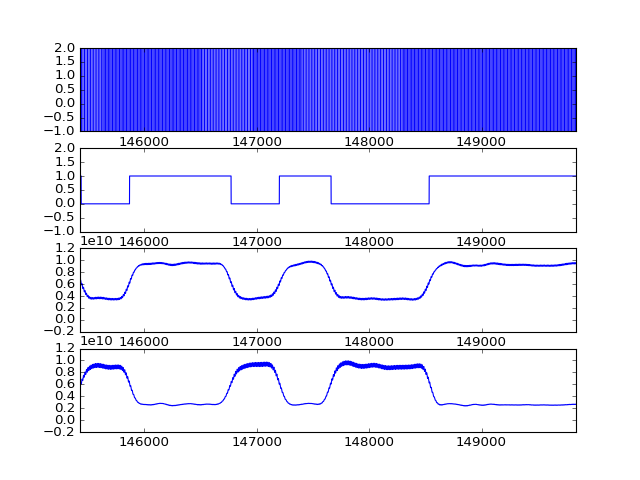

(145430, 149840.0)

In [153]:
start = 145430

plt.figure()
plt.subplot(4,1,1)
plt.plot(data)
plt.xlim(start, start + .1 * rate)
plt.ylim(-1,2)

plt.subplot(4,1,2)
plt.plot(digital)
plt.xlim(start, start + .1 * rate)
plt.ylim(-1,2)

plt.subplot(4,1,3)
plt.plot(upper_band_smooth)
plt.xlim(start, start + .1 * rate)
#plt.ylim(-1,2)

plt.subplot(4,1,4)
plt.plot(lower_band_smooth)
plt.xlim(start, start + .1 * rate)
#plt.ylim(-1,2)

In [103]:
new_start = int(2.8 * rate)

<IPython.core.display.Javascript object>


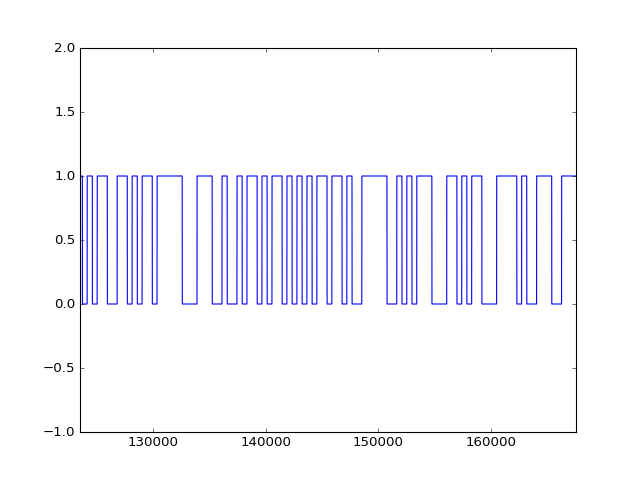

In [104]:
dview(digital,new_start)

In [178]:
#start = (2.8*rate)
baud = 100
cycle = seconds_to_samples(1/baud)

#start = (2.8 * rate) + cycle
start = 254663 + 2*cycle
Run = namedtuple('Run',['value','start_sample','end_sample','length'])


def get_num_in_row(arr,start,cycle):
    start = int(start)
    counter = start
    for k,g in groupby(arr[start:]):
        size = len(list(g))
        length = int( np.rint(size/cycle) )
        yield Run(k, counter, counter+size, length)
        counter += size
        
def view_rows(rows):
    row_reprs = ''.join( [ str(int(row.value)) * row.length for row in rows ] )
    return ''.join(row_reprs)

def get_row_by_bit_number(rows,bits):
    counter = 0
    for i, row in enumerate(rows):
        if counter+row.length >= bits:
            return i,row
        counter += row.length
    
class Char( namedtuple('Char', ['sequence','sample']) ):
    __slots__ = ()
    
    @property
    def char(self):
        return get_ccir(self.sequence)
    
    def __repr__(self):
        return f"Char(sequence={self.sequence}, sample={self.sample}, char={self.char})"
    
def chunk_rows(rows):
    result = []
    cur_sequence = ""
    start_sample = rows[0].start_sample
    for row in rows:
        for i in range(row.length):
            cur_sequence += str(int(row.value))
            if len(cur_sequence) == 7:
                result.append(Char(cur_sequence, start_sample))
                cur_sequence = ""
                start_sample = row.start_sample
    return result

def str_to_ccir(string):
    string = string.upper()
    return ''.join( [ get_id(c) for c in string ] )
    
rows = list(get_num_in_row(digital, start, cycle))

In [179]:
get_row_by_bit_number(rows,51)

(30, Run(value=True, start_sample=276408, end_sample=278198, length=4))

In [180]:
'111100010111001101'
view_rows(rows)

'111100011010110110011100101101101010110010110101111000111001010110110101100110011011110001001110101101100101101100110100101110011101100101101011010110101001011101101101001011001110101101010101101011011011011000011101101010101011010110101110110001101011010101011011001101010011101011010101011010110110011010100111011001101010110110111000110101110101010011011011100101110010100111101010100011110111001011010101001101101011000111110010110110101011001011010111100011100101011011010110010011101111000101011010110110001011100111011001011010110111100010010111001011110010110110110111000100111010010111010110101101101110001001110110011010101101110101011100011000111100110110011011101010011010110001110110110100110100111010110101010110101101101011100001110111100010101101100110110111000110110111000100111011001101010110101101100110101001110111001010101101101100101101010010111110010101101101011001100111000101110110011011011011110001001110011001111110000110011111100001100111111000011001111110000110011111100

In [181]:
chunk_rows(rows)

[Char(sequence=1111000, sample=255545, char=None),
 Char(sequence=1101011, sample=257327, char=None),
 Char(sequence=0110011, sample=260866, char=None),
 Char(sequence=1001011, sample=263975, char=S),
 Char(sequence=0110101, sample=267082, char=G),
 Char(sequence=0110010, sample=270635, char=None),
 Char(sequence=1101011, sample=273758, char=None),
 Char(sequence=1100011, sample=276408, char=Z),
 Char(sequence=1001010, sample=279515, char=None),
 Char(sequence=1101101, sample=283082, char=None),
 Char(sequence=0110011, sample=286172, char=None),
 Char(sequence=0011011, sample=288838, char=F),
 Char(sequence=1100010, sample=291946, char=None),
 Char(sequence=0111010, sample=295513, char=X),
 Char(sequence=1101100, sample=298623, char=None),
 Char(sequence=1011011, sample=301284, char=None),
 Char(sequence=0011010, sample=304378, char=None),
 Char(sequence=0101110, sample=307946, char=Q),
 Char(sequence=0111011, sample=311055, char=None),
 Char(sequence=0010110, sample=313704, char=None)

<IPython.core.display.Javascript object>


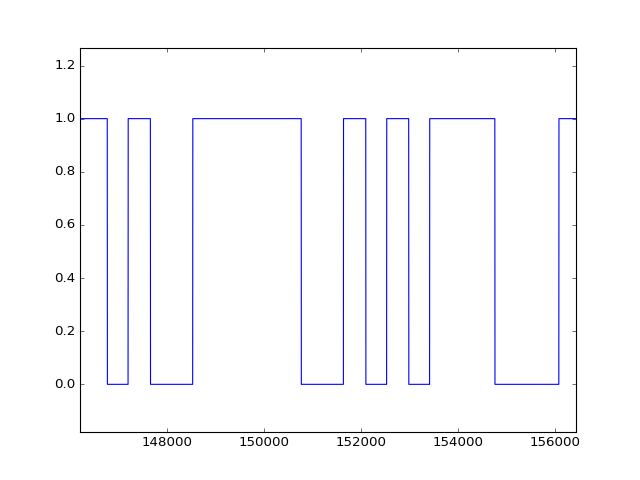

In [147]:
dview(digital,start)

In [154]:
view_rows(rows).find('1111000')

248

In [182]:
str_to_ccir('Welcome to Wikipedia the free encyclopedia that anyone can edit')

'010011110101101100101001110111100010111001101011000100111010011100010010001001111001101001111010011010101101101011010100111001101100011100100111010011010011010110001000011011101010110101101010110001001010110101100100111010101011001110111001011110001010110110101101010011100110110001110010011101001101001100011111101000010010001111011001010101111100011011001101011000100001110110001111011001001001010110101001110011011110100'

In [156]:
get_row_by_bit_number(rows,248)

(145, Run(value=False, start_sample=254663, end_sample=255539, length=2))